In [2]:
## Install necessary libraries
%pip install -q -r ../requirements.txt


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# configure tensorflow for M1 max with 32 GPU cores
import tensorflow as tf
import os

def configure_tensorflow():
    # Physical devices configuration
    physical_devices = tf.config.list_physical_devices()
    print("Available devices:", physical_devices)

    # Configure GPU
    try:
        if tf.config.list_physical_devices('GPU') == 1 :
            tf.config.experimental.set_memory_growth(physical_devices[1], True)

        # Set compute units (GPU cores) utilization
        tf.config.experimental.set_virtual_device_configuration(
            physical_devices[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=24576)]  # 24GB RAM allocation
        )
    except:
        print("No GPU devices found")

    # CPU configuration
    tf.config.threading.set_intra_op_parallelism_threads(7)  # Match your CPU cores
    # tf.config.threading.set_inter_op_parallelism_threads(7)  # Match your CPU cores

    # Mixed precision configuration
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

    # XLA optimization
    tf.config.optimizer.set_jit(False)

    # Additional performance configurations
    os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
    os.environ['TF_GPU_THREAD_COUNT'] = '28'  # Match your GPU cores
    os.environ['TF_USE_CUDNN_BATCHNORM_SPATIAL_PERSISTENT'] = '1'
    os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'
    
    # Metal performance configuration
    os.environ['METAL_DEBUG_ERROR_MODE'] = '0'
    os.environ['METAL_DEVICE_WRAPPER_TYPE'] = '0'

    # return tf.config.get_config()

configure_tensorflow()

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Load ResNet50 model with mixed precision for better performance on Metal
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

#  Fix SSL certificate verification issue
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Load model with Metal GPU optimization
model = tf.keras.applications.ResNet50(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)
print("Model loaded successfully with Metal GPU support")


2025-05-21 16:48:35.721385: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-05-21 16:48:35.721420: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-05-21 16:48:35.721426: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
I0000 00:00:1747842515.721440 8889086 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1747842515.721461 8889086 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model loaded successfully with Metal GPU support


In [6]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Set batch size and image size
BATCH_SIZE = 32
IMAGE_SIZE = 224
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_data(data):
    """Preprocess ImageNet data for ResNet50"""
    image = tf.cast(data['image'], tf.float32)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    label = data['label']
    return image, label

# Load ImageNet test dataset - 13 minutes to load data
dataset, info = tfds.load(
    'imagenet2012',
    shuffle_files=False,
    with_info=True,
    data_dir='../datasets'  # Using your local ImageNet data
)


In [7]:
# Evaluation
# Configure the dataset for performance
test_dataset = dataset['test'].map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(AUTOTUNE)

# test_dataset
# Evaluate the model
# model.summary()
model.compile(
	optimizer='adam',
	loss='sparse_categorical_crossentropy',
	metrics=['accuracy']
)
# model.evaluate(test_dataset, verbose=1)

In [ ]:
import numpy as np
# Get predictions
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)


2025-05-21 16:48:39.119399: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-05-21 16:48:40.351397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2172/3125 ━━━━━━━━━━━━━━━━━━━━ 2:15 142ms/step

In [ ]:
g = [y for _, y in test_dataset]

NameError: name 'test_dataset' is not defined

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your model is loaded and named `model`
# Assuming (X_test, y_test) are your test data and labels

# Step 1: Evaluate the Model
# y_pred_prob = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax([y for _, y in test_dataset], axis=1)

# Step 2: Classification Report
report = classification_report(y_true, y_pred, output_dict=True)
print(report)

# Step 3: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Step 5: ROC Curve and AUC (for binary classification)
if len(np.unique(y_true)) == 2:  # Check if binary
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [3125, 100000]

2025-05-21 13:22:26.037328: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at scatter_nd_op.cc:132 : INVALID_ARGUMENT: Dimension -9223372036854775807 must be >= 0
2025-05-21 13:22:26.037349: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Dimension -9223372036854775807 must be >= 0


InvalidArgumentError: {{function_node __wrapped__ScatterNd_device_/job:localhost/replica:0/task:0/device:CPU:0}} Dimension -9223372036854775807 must be >= 0 [Op:ScatterNd] name: 

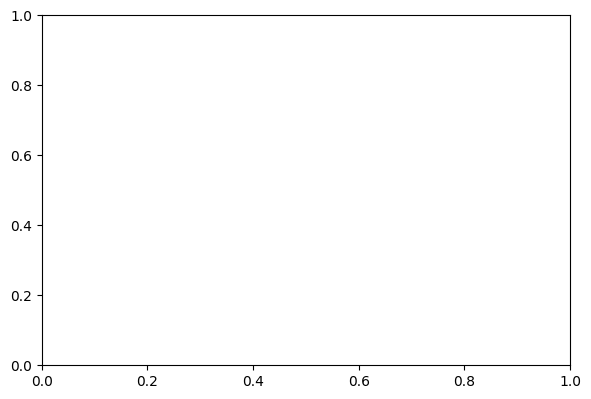

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Filter out invalid labels (negative values)
valid_indices = y_true >= 0
y_true_filtered = y_true[valid_indices]
y_pred_filtered = y_pred[valid_indices]
predictions_filtered = predictions[valid_indices]

# Create figure with subplots
# plt.style.use('seaborn')
fig = plt.figure(figsize=(15, 10))

# 1. Confusion Matrix
plt.subplot(2, 2, 1)
cm = tf.math.confusion_matrix(y_true_filtered, y_pred_filtered)
sns.heatmap(cm[:10, :10], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (First 10 Classes)')
plt.xlabel('Predicted')
plt.ylabel('True')

# 2. Accuracy per class
plt.subplot(2, 2, 2)
class_accuracy = (cm.diag() / (cm.sum(axis=1) + 1e-6)) * 100  # Added small epsilon to avoid division by zero
plt.hist(class_accuracy, bins=20)
plt.title('Distribution of Class Accuracies')
plt.xlabel('Accuracy (%)')
plt.ylabel('Number of Classes')

# 3. Top-5 errors
plt.subplot(2, 2, 3)
top5_accuracy = tf.keras.metrics.sparse_top_k_categorical_accuracy(
    y_true_filtered, predictions_filtered, k=5
)
plt.bar(['Top-1', 'Top-5'], 
        [np.mean(y_true_filtered == y_pred_filtered) * 100, np.mean(top5_accuracy) * 100])
plt.title('Top-1 vs Top-5 Accuracy')
plt.ylabel('Accuracy (%)')

# 4. Confidence Distribution
plt.subplot(2, 2, 4)
confidences = np.max(predictions_filtered, axis=1)
sns.kdeplot(data=pd.DataFrame({
    'Confidence': confidences,
    'Correct': y_true_filtered == y_pred_filtered
}), x='Confidence', hue='Correct')
plt.title('Prediction Confidence Distribution')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Valid samples: {np.sum(valid_indices)} out of {len(y_true)}")
print(f"Top-1 Accuracy: {np.mean(y_true_filtered == y_pred_filtered)*100:.2f}%")
print(f"Top-5 Accuracy: {np.mean(top5_accuracy)*100:.2f}%")
print(f"Mean Confidence: {np.mean(confidences)*100:.2f}%")
print(f"Median Confidence: {np.median(confidences)*100:.2f}%")